In [14]:
import polars as pl
import numpy as np

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import root_mean_squared_error

import lightgbm as lgb

import seaborn as sns

In [2]:
pl.__version__

'1.5.0'

In [3]:
lgb.__version__

'4.5.0'

In [4]:
df = pl.DataFrame(
    {
        "feature1": range(100),
        "feature2": range(100, 200),
        "feat_category": ["A", "B", "C", "D"] * 25,
        "target": [x * 0.5 + 10 for x in range(100)],
    }
)

# df = pl.read_csv("../../input/titanic.csv")

In [5]:
USE_COL = ["feature1", "feature2", "feat_category"]
CATEGORICAL_FEATURE = ["feat_category"]
TARGET_COL = "target"
FOLD_NUM = 5
SEED = 42

In [6]:
# 学習データとテストデータに分割する
train, test = train_test_split(
    df,
    test_size=0.3,
    random_state=SEED,
    shuffle=True,
    # stratify=df.get_column(TARGET_COL),
)

In [7]:
# Categorical型への変換
train = train.with_columns(pl.col(CATEGORICAL_FEATURE).cast(pl.Categorical))
test = test.with_columns(pl.col(CATEGORICAL_FEATURE).cast(pl.Categorical))

In [8]:
# Foldの作成
fold_arr = np.zeros(train.height)
fold = KFold(n_splits=FOLD_NUM, shuffle=True, random_state=SEED)

for idx, (_, val_idx) in enumerate(fold.split(train)):
    fold_arr[val_idx] = idx

train = train.with_columns(pl.Series(fold_arr).cast(pl.Int64).alias("fold"))

In [11]:
# LightGBMで用いるパラメータを指定
params = {
    "objective": "regression",
    "metric": "rmse",
    "max_depth": -1,
    "min_data_in_leaf": 10,  # 1つの葉に入る最小のデータ数
    "num_leaves": 24,  # 2**max_depthより少し小さめにすると過学習を防げる
    "learning_rate": 0.01,  # 1回のiterationで学習を進める割合、大きいと学習が早く終わる。小さいと学習は長いが高精度になりやすい。
    "bagging_freq": 5,  # 指定した回数ごとにbaggingを行う
    "feature_fraction": 0.9,  # 1回のiterationで利用する特徴量(列方向)の割合
    "bagging_fraction": 0.8,  # 1回のiterationで利用するデータ(行方向)の割合
    "verbose": -1,  # 出力するログレベルの変更、-1はFatalなログのみを出力
    "seed": SEED,  # ランダムシードの固定
    "lambda_l1": 0.4,  # 正則化のためのパラメータ
    "lambda_l2": 0.4,  # 正則化のためのパラメータ
}

In [12]:
# テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
models = []

# Cross Validationによる学習の実施
for fold in range(FOLD_NUM):
    print(f"Start fold {fold}")

    # foldごとにtrainとvalidに分ける
    train_fold = train.filter(pl.col("fold") != fold)
    valid_fold = train.filter(pl.col("fold") == fold)

    # X(説明変数)とy(目的変数)に分ける
    X_train = train_fold.select(USE_COL)
    X_valid = valid_fold.select(USE_COL)
    y_train = train_fold.select(TARGET_COL)
    y_valid = valid_fold.select(TARGET_COL)

    # LightGBMが認識可能な形にデータセットを変換
    lgb_train = lgb.Dataset(X_train.to_pandas(), y_train.to_pandas())
    lgb_eval = lgb.Dataset(
        X_valid.to_pandas(), y_valid.to_pandas(), reference=lgb_train
    )

    # モデルの学習
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,  # 学習のiteration回数
        valid_sets=[lgb_train, lgb_eval],
        callbacks=[
            lgb.early_stopping(
                stopping_rounds=100
            ),  # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
            lgb.log_evaluation(100),  # 指定したiteration回数ごとにlogを出力する
        ],
    )

    # モデルを保存
    models.append([fold, model])

Start fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 6.15513	valid_1's rmse: 9.34773
[200]	training's rmse: 3.3575	valid_1's rmse: 5.66925
[300]	training's rmse: 2.56277	valid_1's rmse: 4.1384
[400]	training's rmse: 2.39872	valid_1's rmse: 3.5368
[500]	training's rmse: 2.36418	valid_1's rmse: 3.31859
[600]	training's rmse: 2.35806	valid_1's rmse: 3.22407
[700]	training's rmse: 2.356	valid_1's rmse: 3.20173
[800]	training's rmse: 2.34833	valid_1's rmse: 3.18737
Early stopping, best iteration is:
[760]	training's rmse: 2.35134	valid_1's rmse: 3.16555
Start fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 6.31701	valid_1's rmse: 5.75742
[200]	training's rmse: 3.21711	valid_1's rmse: 3.15152
[300]	training's rmse: 2.20665	valid_1's rmse: 2.31393
[400]	training's rmse: 1.93062	valid_1's rmse: 2.03443
[500]	training's rmse: 1.87636	valid_1's rmse: 1.95129
[600]	training's rmse: 1.85934	valid_1's rmse: 1.8

In [15]:
# 学習データ全体に対する推論結果を保存するobjectを作成
oof = np.zeros((len(train)))

# foldの値と学習済みモデルを利用し、モデルの評価を行う
for fold, model in models:
    valid_fold = train.filter(pl.col("fold") == fold)

    X_valid = valid_fold.select(USE_COL)
    y_valid = valid_fold.select(TARGET_COL)

    # validデータに対する推論
    y_valid_pred = model.predict(
        X_valid.to_pandas(), num_iteration=model.best_iteration
    )

    score = root_mean_squared_error(y_valid, y_valid_pred)
    print(f"fold {fold} Score: {score}")

    is_valid = train.get_column("fold") == fold
    oof[is_valid] = y_valid_pred

fold 0 Score: 3.165547226658896
fold 1 Score: 1.7922859720463291
fold 2 Score: 1.6085584075926749
fold 3 Score: 2.1556547445493686
fold 4 Score: 1.945253096494813


In [16]:
oof_score = root_mean_squared_error(train.get_column(TARGET_COL), oof)
oof_score

np.float64(2.2023303742881004)

<Axes: >

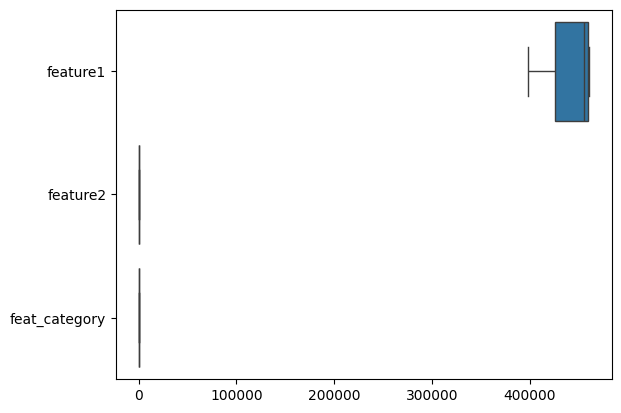

In [17]:
import pandas as pd

feature_importances = [
    model.feature_importance(importance_type="gain") for _, model in models
]
feature_importances_df = pd.DataFrame(feature_importances, columns=USE_COL)

order = feature_importances_df.mean().sort_values(ascending=False).index.tolist()

sns.boxplot(data=feature_importances_df, orient="h", order=order)

In [18]:
pred = np.array([model.predict(test[USE_COL].to_pandas()) for _, model in models])
pred = np.mean(pred, axis=0)
pred

array([52.44307486, 35.90955414, 44.73829737, 32.53883583, 31.05920578,
       30.24133921, 19.11700965, 50.88147948, 15.98959675, 15.98959675,
       15.98959675, 24.21024827, 45.48070381, 25.71339754, 54.90344146,
       15.98959675, 48.94659732, 50.11787051, 15.98959675, 24.86748648,
       37.00664841, 54.90344146, 22.36427774, 30.24133921, 44.73829737,
       15.98959675, 30.24133921, 54.90344146, 15.98959675, 44.73829737])